In [1]:


import joblib
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import linear_model




pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)




In [2]:
df = pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
def check_df(dataframe, head=5):

    print("~~~~~~~~~~~~~~~~~~~~~~~~ SHAPE ~~~~~~~~~~~~~~~~~~~~~~~~")
    print(dataframe.shape)
    print("~~~~~~~~~~~~~~~~~~~~~~~~ TYPES ~~~~~~~~~~~~~~~~~~~~~~~~")
    print(dataframe.dtypes)
    print("~~~~~~~~~~~~~~~~~~~~~~~~ HEAD ~~~~~~~~~~~~~~~~~~~~~~~~")
    print(dataframe.head(head))
    print("~~~~~~~~~~~~~~~~~~~~~~~~ TAIL ~~~~~~~~~~~~~~~~~~~~~~~~")
    print(dataframe.tail(head))
    print("~~~~~~~~~~~~~~~~~~~~~~~~  NA  ~~~~~~~~~~~~~~~~~~~~~~~~")
    print(dataframe.isnull().sum())
    print("~~~~~~~~~~~~~~~~~~~~~~~~ DESCRIBE ~~~~~~~~~~~~~~~~~~~~~~~~")
    print(dataframe.describe().T)


In [4]:
check_df(df,head=7)

~~~~~~~~~~~~~~~~~~~~~~~~ SHAPE ~~~~~~~~~~~~~~~~~~~~~~~~
(7043, 21)
~~~~~~~~~~~~~~~~~~~~~~~~ TYPES ~~~~~~~~~~~~~~~~~~~~~~~~
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~ HEAD ~~~~~~~~~~~~~~~~~~~~~~~~
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0  7590-VHVEG  Female              0     Yes     

In [5]:
df.drop("customerID", axis = 1 , inplace = True)

In [6]:
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')

In [7]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


In [8]:
cat_cols,num_cols,cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 20
cat_cols: 17
num_cols: 3
cat_but_car: 0
num_but_cat: 1


In [9]:
def target_summary_with_cat(dataframe, target, categorical_col, cat_col_v2):

    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby([categorical_col, cat_col_v2])[target].mean(),
                        "TARGET_COUNT": dataframe.groupby([categorical_col, cat_col_v2])[target].count()}), end="\n\n\n")

In [10]:
for i in cat_cols:
    target_summary_with_cat(df, "MonthlyCharges","InternetService",i)

                        TARGET_MEAN  TARGET_COUNT
InternetService gender                           
DSL             Female    58.590741          1188
                Male      57.631427          1233
Fiber optic     Female    91.472569          1553
                Male      91.527868          1543
No              Female    21.110710           747
                Male      21.048973           779


                         TARGET_MEAN  TARGET_COUNT
InternetService Partner                           
DSL             No         53.982761          1253
                Yes        62.521361          1168
Fiber optic     No         88.480562          1600
                Yes        94.729612          1496
No              No         20.726459           788
                Yes        21.455827           738


                            TARGET_MEAN  TARGET_COUNT
InternetService Dependents                           
DSL             No            56.443781          1616
                Yes       

In [11]:
for i in cat_cols:
    target_summary_with_cat(df, "MonthlyCharges","PhoneService",i)

                     TARGET_MEAN  TARGET_COUNT
PhoneService gender                           
No           Female    42.296979           331
             Male      41.775499           351
Yes          Female    67.605987          3157
             Male      66.798065          3204


                      TARGET_MEAN  TARGET_COUNT
PhoneService Partner                           
No           No         39.547305           371
             Yes        44.988585           311
Yes          No         64.486147          3270
             Yes        70.069039          3091


                         TARGET_MEAN  TARGET_COUNT
PhoneService Dependents                           
No           No            41.126576           476
             Yes           44.112864           206
Yes          No            69.766345          4457
             Yes           61.189338          1904


                           TARGET_MEAN  TARGET_COUNT
PhoneService PhoneService                           
No          

In [12]:
def cat_summary(dataframe, col_name, plot=True):

    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


     PhoneService      Ratio
Yes          6361  90.316626
No            682   9.683374
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


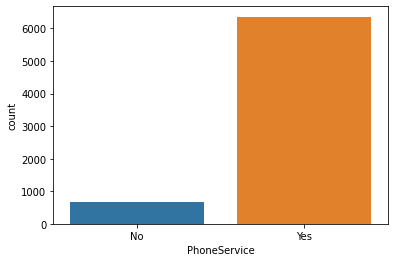

             InternetService      Ratio
Fiber optic             3096  43.958540
DSL                     2421  34.374556
No                      1526  21.666903
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


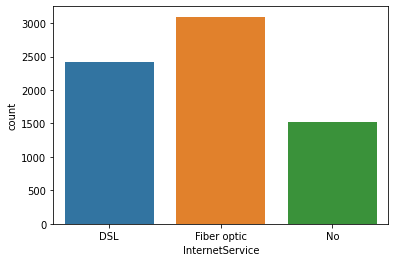

                  MultipleLines      Ratio
No                         3390  48.132898
Yes                        2971  42.183729
No phone service            682   9.683374
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


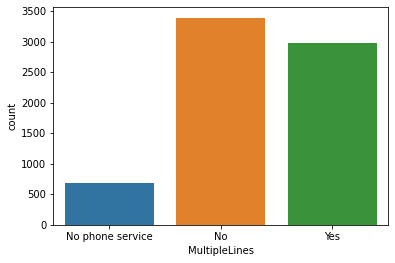

                     OnlineSecurity      Ratio
No                             3498  49.666335
Yes                            2019  28.666761
No internet service            1526  21.666903
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


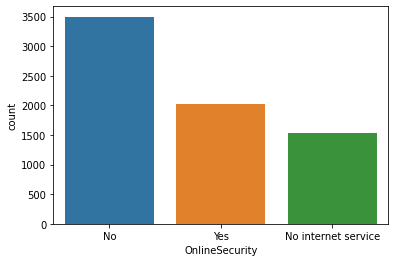

                     OnlineBackup      Ratio
No                           3088  43.844952
Yes                          2429  34.488144
No internet service          1526  21.666903
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


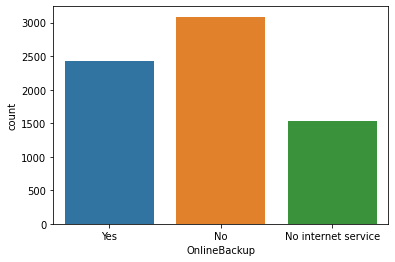

                     DeviceProtection      Ratio
No                               3095  43.944342
Yes                              2422  34.388755
No internet service              1526  21.666903
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


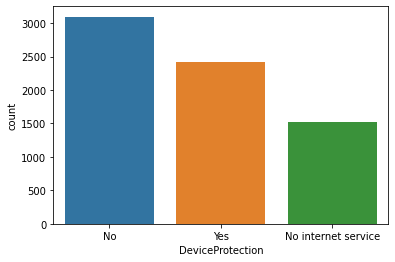

                     TechSupport      Ratio
No                          3473  49.311373
Yes                         2044  29.021724
No internet service         1526  21.666903
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


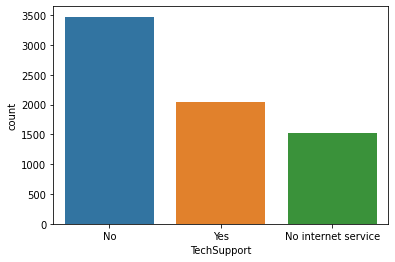

                     StreamingTV      Ratio
No                          2810  39.897771
Yes                         2707  38.435326
No internet service         1526  21.666903
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


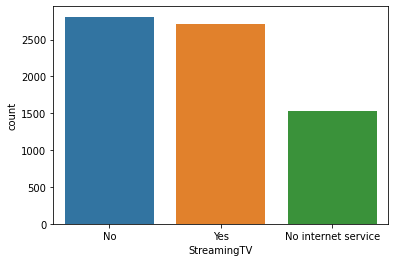

                     StreamingMovies      Ratio
No                              2785  39.542808
Yes                             2732  38.790288
No internet service             1526  21.666903
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


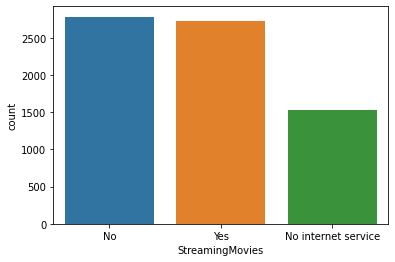

In [13]:
services = ['PhoneService','InternetService','MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
for col in services:
    cat_summary(df, col)  

In [14]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.000,55.0000,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80


<AxesSubplot:xlabel='Churn', ylabel='MonthlyCharges'>

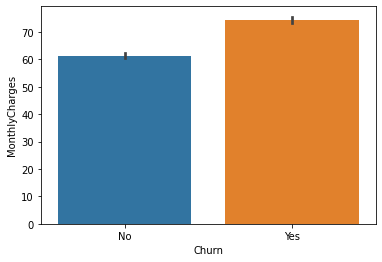

In [15]:
sns.barplot(x ='Churn', y ='MonthlyCharges', data = df )

<AxesSubplot:xlabel='Churn', ylabel='tenure'>

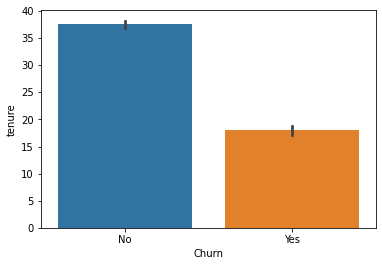

In [16]:
sns.barplot(x ='Churn', y ='tenure', data = df )


<AxesSubplot:xlabel='MonthlyCharges', ylabel='TotalCharges'>

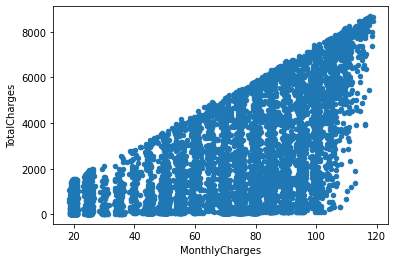

In [17]:
df[['MonthlyCharges', 'TotalCharges']].plot.scatter(x = 'MonthlyCharges',y='TotalCharges')


        gender     Ratio
Male      3555  50.47565
Female    3488  49.52435
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


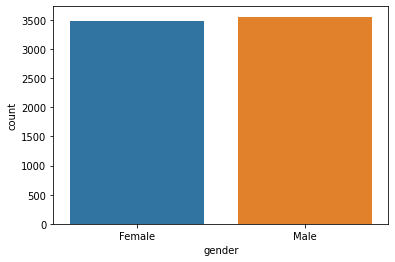

     Partner     Ratio
No      3641  51.69672
Yes     3402  48.30328
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


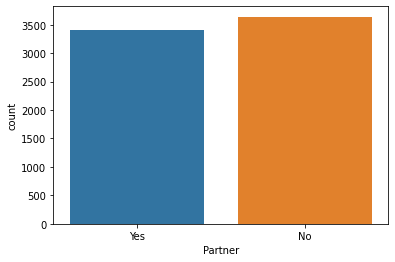

     Dependents      Ratio
No         4933  70.041176
Yes        2110  29.958824
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


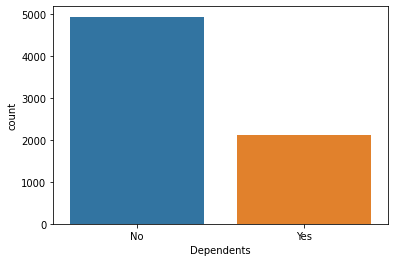

   SeniorCitizen      Ratio
0           5901  83.785319
1           1142  16.214681
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


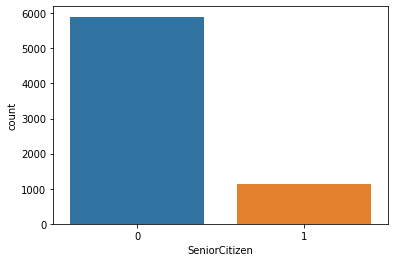

In [18]:
c_info = ['gender', 'Partner', 'Dependents','SeniorCitizen']
for col in c_info:
    cat_summary(df, col)   

                Contract      Ratio
Month-to-month      3875  55.019168
Two year            1695  24.066449
One year            1473  20.914383
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


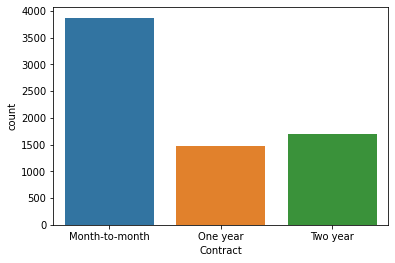

     PaperlessBilling      Ratio
Yes              4171  59.221922
No               2872  40.778078
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


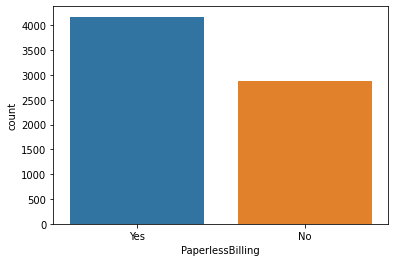

                           PaymentMethod      Ratio
Electronic check                    2365  33.579441
Mailed check                        1612  22.887974
Bank transfer (automatic)           1544  21.922476
Credit card (automatic)             1522  21.610109
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


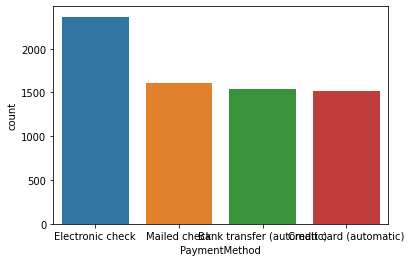

In [19]:
acc_info = ['Contract','PaperlessBilling','PaymentMethod'] 
for col in acc_info:
    cat_summary(df, col) 


In [20]:
def num_summary(dataframe, numerical_col, plot=True):

    quantiles = [0.05, 0.10, 0.20, 0.40, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]

    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()


count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
5%          1.000000
10%         2.000000
20%         6.000000
40%        20.000000
50%        29.000000
60%        40.000000
70%        50.000000
80%        60.000000
90%        69.000000
95%        72.000000
99%        72.000000
max        72.000000
Name: tenure, dtype: float64


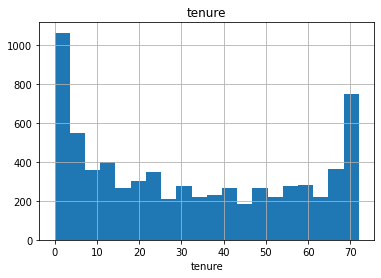

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
5%         19.650000
10%        20.050000
20%        25.050000
40%        58.830000
50%        70.350000
60%        79.100000
70%        85.500000
80%        94.250000
90%       102.600000
95%       107.400000
99%       114.729000
max       118.750000
Name: MonthlyCharges, dtype: float64


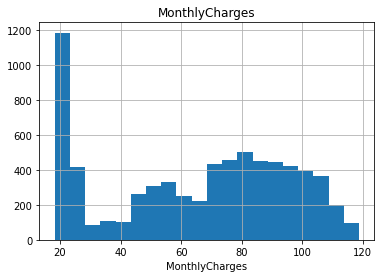

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
5%         49.605000
10%        84.600000
20%       267.070000
40%       944.170000
50%      1397.475000
60%      2048.950000
70%      3141.130000
80%      4475.410000
90%      5976.640000
95%      6923.590000
99%      8039.883000
max      8684.800000
Name: TotalCharges, dtype: float64


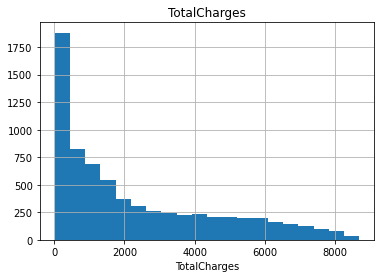

In [21]:
#scan all the num columns
for col in num_cols:
    num_summary(df, col)

In [22]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


In [23]:
df.dropna(inplace=True)


tenure False
MonthlyCharges False
TotalCharges False


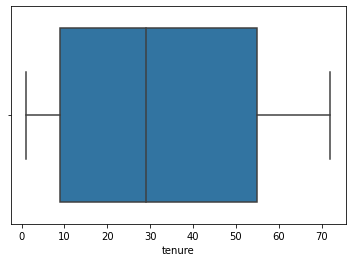

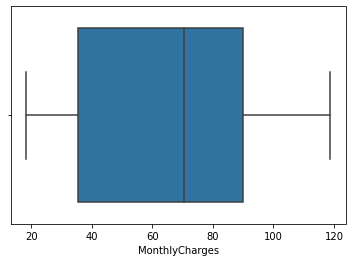

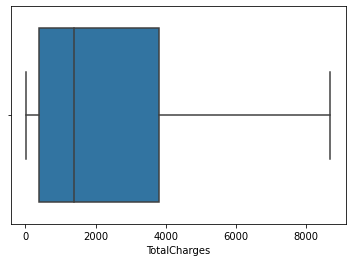

In [24]:
for col in num_cols:
    print(col, check_outlier(df, col))


for i in num_cols:
    sns.boxplot(x=df[i])
    plt.show()

In [25]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [26]:
df = one_hot_encoder(df, cat_cols, drop_first=True)


In [27]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)


Observations: 7032
Variables: 31
cat_cols: 28
num_cols: 3
cat_but_car: 0
num_but_cat: 28


In [28]:
X_scaled = StandardScaler().fit_transform(df[num_cols])
df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

In [29]:
df.isnull().sum()


tenure                                   11
MonthlyCharges                           11
TotalCharges                             11
gender_Male                               0
Partner_Yes                               0
Dependents_Yes                            0
PhoneService_Yes                          0
MultipleLines_No phone service            0
MultipleLines_Yes                         0
InternetService_Fiber optic               0
InternetService_No                        0
OnlineSecurity_No internet service        0
OnlineSecurity_Yes                        0
OnlineBackup_No internet service          0
OnlineBackup_Yes                          0
DeviceProtection_No internet service      0
DeviceProtection_Yes                      0
TechSupport_No internet service           0
TechSupport_Yes                           0
StreamingTV_No internet service           0
StreamingTV_Yes                           0
StreamingMovies_No internet service       0
StreamingMovies_Yes             

In [30]:
df.dropna(inplace=True)


In [31]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)


Observations: 7021
Variables: 31
cat_cols: 28
num_cols: 3
cat_but_car: 0
num_but_cat: 28


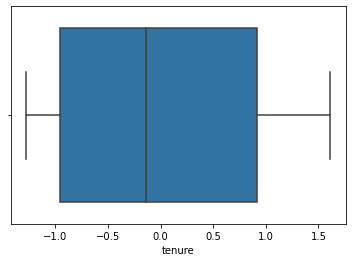

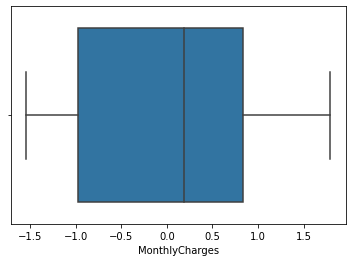

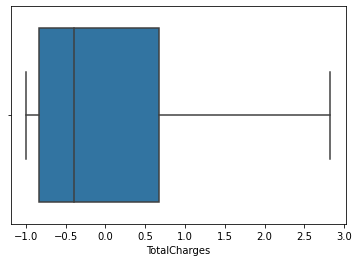

In [32]:
for i in num_cols:
    sns.boxplot(x=df[i])
    plt.show()


In [33]:
check_df(df)


~~~~~~~~~~~~~~~~~~~~~~~~ SHAPE ~~~~~~~~~~~~~~~~~~~~~~~~
(7021, 31)
~~~~~~~~~~~~~~~~~~~~~~~~ TYPES ~~~~~~~~~~~~~~~~~~~~~~~~
tenure                                   float64
MonthlyCharges                           float64
TotalCharges                             float64
gender_Male                                uint8
Partner_Yes                                uint8
Dependents_Yes                             uint8
PhoneService_Yes                           uint8
MultipleLines_No phone service             uint8
MultipleLines_Yes                          uint8
InternetService_Fiber optic                uint8
InternetService_No                         uint8
OnlineSecurity_No internet service         uint8
OnlineSecurity_Yes                         uint8
OnlineBackup_No internet service           uint8
OnlineBackup_Yes                           uint8
DeviceProtection_No internet service       uint8
DeviceProtection_Yes                       uint8
TechSupport_No internet service            u

In [34]:
y = df["Churn_Yes"]
X = df.drop(["Churn_Yes"], axis=1)

In [35]:


knn_params = {"n_neighbors": range(2, 50)}

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200],
                  "colsample_bytree": [0.5, 1]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500],
                   "colsample_bytree": [0.7, 1]}

classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)]



In [36]:
def hyperparameter_optimization(X, y, cv=3, scoring="roc_auc"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

In [37]:
best_models = hyperparameter_optimization(X, y)


Hyperparameter Optimization....
########## KNN ##########
roc_auc (Before): 0.7511
roc_auc (After): 0.8014
KNN best params: {'n_neighbors': 44}

########## CART ##########
roc_auc (Before): 0.6106
roc_auc (After): 0.8076
CART best params: {'max_depth': 5, 'min_samples_split': 17}

########## RF ##########
roc_auc (Before): 0.7982
roc_auc (After): 0.8216
RF best params: {'max_depth': 8, 'max_features': 'auto', 'min_samples_split': 20, 'n_estimators': 200}

########## XGBoost ##########
roc_auc (Before): 0.7873
roc_auc (After): 0.8261
XGBoost best params: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}

########## LightGBM ##########
roc_auc (Before): 0.805
roc_auc (After): 0.8176
LightGBM best params: {'colsample_bytree': 1, 'learning_rate': 0.01, 'n_estimators': 300}



In [38]:
def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR',linear_model.LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")



In [39]:
base_models(X, y)

Base Models....
roc_auc: 0.828 (LR) 
roc_auc: 0.7511 (KNN) 
roc_auc: 0.7919 (SVC) 
roc_auc: 0.6128 (CART) 
roc_auc: 0.7986 (RF) 
roc_auc: 0.8201 (Adaboost) 
roc_auc: 0.8198 (GBM) 
roc_auc: 0.7873 (XGBoost) 
roc_auc: 0.805 (LightGBM) 


In [40]:
def voting_classifier(best_models, X, y):
    print("Voting Classifier...")
    voting_clf = VotingClassifier(estimators=[('KNN', best_models["KNN"]), ('RF', best_models["RF"]),
                                              ('LightGBM', best_models["LightGBM"])],
                                  voting='soft').fit(X, y)

    cv_results = cross_validate(voting_clf, X, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    return voting_clf




In [41]:
voting_clf = voting_classifier(best_models, X, y)

Voting Classifier...
Accuracy: 0.7805149989472929
F1Score: 0.525505711180318
ROC_AUC: 0.8203917878016034
